Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


### Загрузка данных

In [1]:
import gdown
# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)      # Скачивание файла

### Импорт библиотек

In [2]:
import numpy as np  # Работа с массивами данных
import re
import tensorflow as tf
import os    # Функции операционной системы
import matplotlib.pyplot as plt # Отрисовка графиков
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix # Матрица ошибок классификатора
%matplotlib inline

### Установка сида

In [3]:
SEED = 52
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# !unzip -qo -O UTF-8 20writers.zip -d writers/

### Функция для разделения текста в пропорциях 80%, 20%

In [5]:
def split_text(s):
  i1 = int(0.8*len(s))
  while s[i1].isalpha() and i1 > 0:
    i1 -= 1
  return s[:i1], s[i1:]

### Классификация

In [6]:
CLASS_LIST = []
text_train = []
text_test = []

for subdir, dirs, files in os.walk('writers'):
    for file in files:
        class_name = re.match('(.+)(?=(\.txt))', file)[0]
        if class_name not in CLASS_LIST:
            print(f'Добавление класса "{class_name}"')
            CLASS_LIST.append(class_name)
            text_train.append('')
            text_test.append('')
        # Поиск индекса класса для добавления содержимого файла в выборку
        cls = CLASS_LIST.index(class_name)

        with open(f'{subdir}/{file}', 'r', encoding='utf-8') as f:
            text = f.read()

        text_train[cls] += ' ' + split_text(text)[0].replace('\n', ' ')
        text_test[cls] += ' ' + split_text(text)[1].replace('\n', ' ')

Добавление класса "Беляев"
Добавление класса "Гоголь"
Добавление класса "Горький"
Добавление класса "Грибоедов"
Добавление класса "Достоевский"
Добавление класса "Куприн"
Добавление класса "Лермонтов"
Добавление класса "Носов"
Добавление класса "Пастернак"
Добавление класса "Пушкин"
Добавление класса "Толстой"
Добавление класса "Тургенев"
Добавление класса "Чехов"


### Проверка определения классов

In [7]:
CLASS_COUNT = len(CLASS_LIST)
print(f"{len(text_train)} текстов от {len(CLASS_LIST)} авторов")
CLASS_LIST[0]

13 текстов от 13 авторов


'Беляев'

### Проверка текстов для тренировки

In [8]:
text_train[0][:200]

' \ufeffЧасть первая  I. На палубе   Большой трансатлантический пароход «Вениамин Франклин» стоял в генуэзской гавани, готовый к отплытию. На берегу была обычная суета, слышались крики разноязычной, пестрой'

### Вывод количества слов для каждого класса

In [9]:
def data_summary(df, class_labels):
    for i, cls in enumerate(class_labels):
        print(f'Количество слов в классе {cls}:\
               {len([word for word in df[i].split()])}')

data_summary(text_train, CLASS_LIST)

Количество слов в классе Беляев:               277294
Количество слов в классе Гоголь:               249105
Количество слов в классе Горький:               339676
Количество слов в классе Грибоедов:               123221
Количество слов в классе Достоевский:               663163
Количество слов в классе Куприн:               288079
Количество слов в классе Лермонтов:               253411
Количество слов в классе Носов:               308209
Количество слов в классе Пастернак:               378044
Количество слов в классе Пушкин:               411686
Количество слов в классе Толстой:               431004
Количество слов в классе Тургенев:               255117
Количество слов в классе Чехов:               853278


### Параметры

In [10]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 2000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 200                          # Шаг окна разбиения текста на векторы

### Токенизация

Использованы параметры: <br>
num_words   - объем словаря <br>
filters     - убираемые из текста ненужные символы <br>
lower       - приведение слов к нижнему регистру <br>
split       - разделитель слов <br>
char_level  - указание разделять по словам, а не по единичным символам <br>
oov_token   - токен для слов, которые не вошли в словарь

In [11]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='неизвестное_слово',
                      char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_train)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

### Вывод нескольких наиболее часто встречающихся слов и размера словаря

In [12]:
print(items[:120])
print("Размер словаря: ", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6), ('я', 7), ('с', 8), ('он', 9), ('как', 10), ('а', 11), ('то', 12), ('его', 13), ('к', 14), ('но', 15), ('это', 16), ('по', 17), ('за', 18), ('она', 19), ('у', 20), ('так', 21), ('же', 22), ('из', 23), ('все', 24), ('от', 25), ('вы', 26), ('было', 27), ('мне', 28), ('ты', 29), ('меня', 30), ('ее', 31), ('о', 32), ('бы', 33), ('да', 34), ('только', 35), ('ему', 36), ('был', 37), ('когда', 38), ('еще', 39), ('сказал', 40), ('вот', 41), ('мы', 42), ('они', 43), ('уже', 44), ('ни', 45), ('их', 46), ('для', 47), ('до', 48), ('нет', 49), ('него', 50), ('ну', 51), ('или', 52), ('если', 53), ('теперь', 54), ('себя', 55), ('быть', 56), ('ли', 57), ('вас', 58), ('всё', 59), ('была', 60), ('во', 61), ('вам', 62), ('даже', 63), ('очень', 64), ('под', 65), ('есть', 66), ('были', 67), ('где', 68), ('чем', 69), ('со', 70), ('может', 71), ('чтобы', 72), ('себе', 73), ('ничего', 74), ('время', 75), ('ей', 76), ('человек', 7

### Преобразование входных текстов в последовательности индексов (для архитектур с embedding) <br>
Применено приведение к массиву объектов для дальнейшего разделения на выборки

In [13]:
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

### Функции разбиения на предложения и формирования выборок

In [14]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

### Формирование выборок

In [15]:
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(23471, 2000) (23471, 13)
(5832, 2000) (5832, 13)


### Формирование выборок текстов в виде разреженных матриц (bag of words)

In [16]:
# На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование типа
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

# Вывод формы обучающей выборки в виде разреженной матрицы Bag of Words
print(x_train_01.shape)
# Вывод фрагмента отрезка обучающего текста в виде Bag of Words
print(x_train_01[0][0:100])

(23471, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1.]


### Создание модели

In [17]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### Модель с Dense-слоями



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 13)               

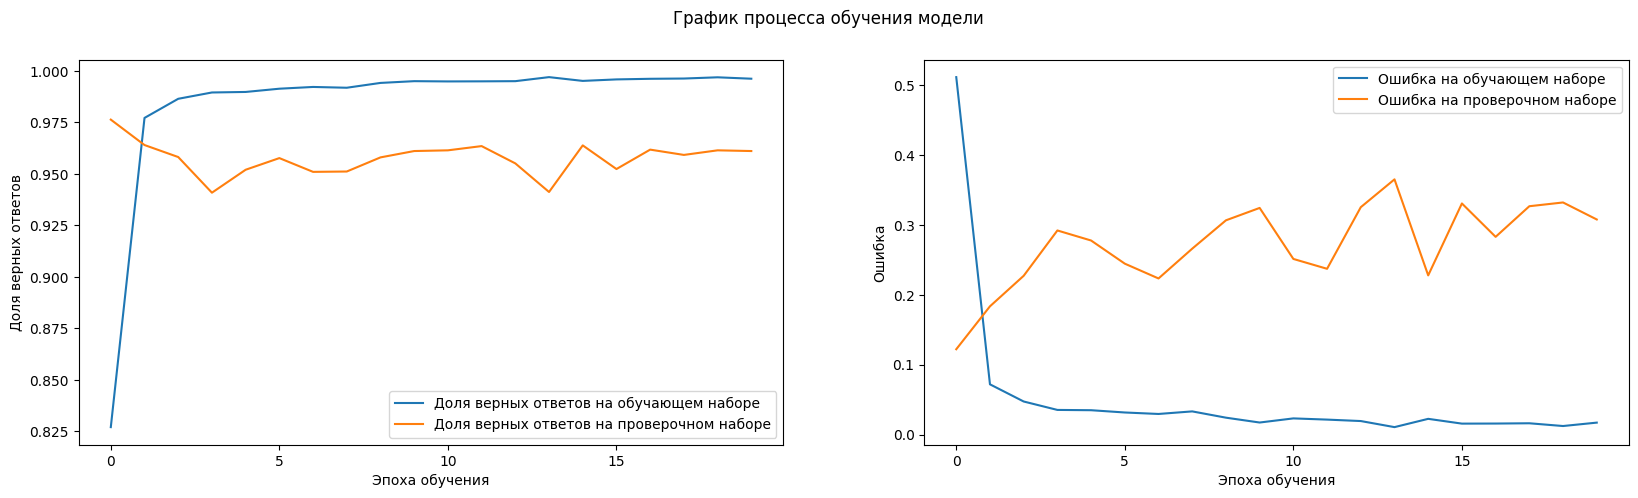

183/183 [==============================] - 1s 3ms/step
----------------------------------------------------------------------------------------------------
Нейросеть: BoW + dense
Класс: Беляев               100% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Гоголь                87% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Горький               99% сеть отнесла к классу Горький              - ВЕРНО :-)
Класс: Грибоедов             96% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Достоевский           98% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Куприн               100% сеть отнесла к классу Куприн               - ВЕРНО :-)
Класс: Лермонтов             72% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Носов                100% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Пастернак            100% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Пушкин                

In [18]:
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(100, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Третий полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='BoW + dense')

In [19]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 1000
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(23471, 1000) (5832, 1000)


### Модель с Embedding слоем

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         4000000   
                                                                 
 conv1d (Conv1D)             (None, 331, 128)          256128    
                                                                 
 conv1d_1 (Conv1D)           (None, 108, 256)          327936    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                       

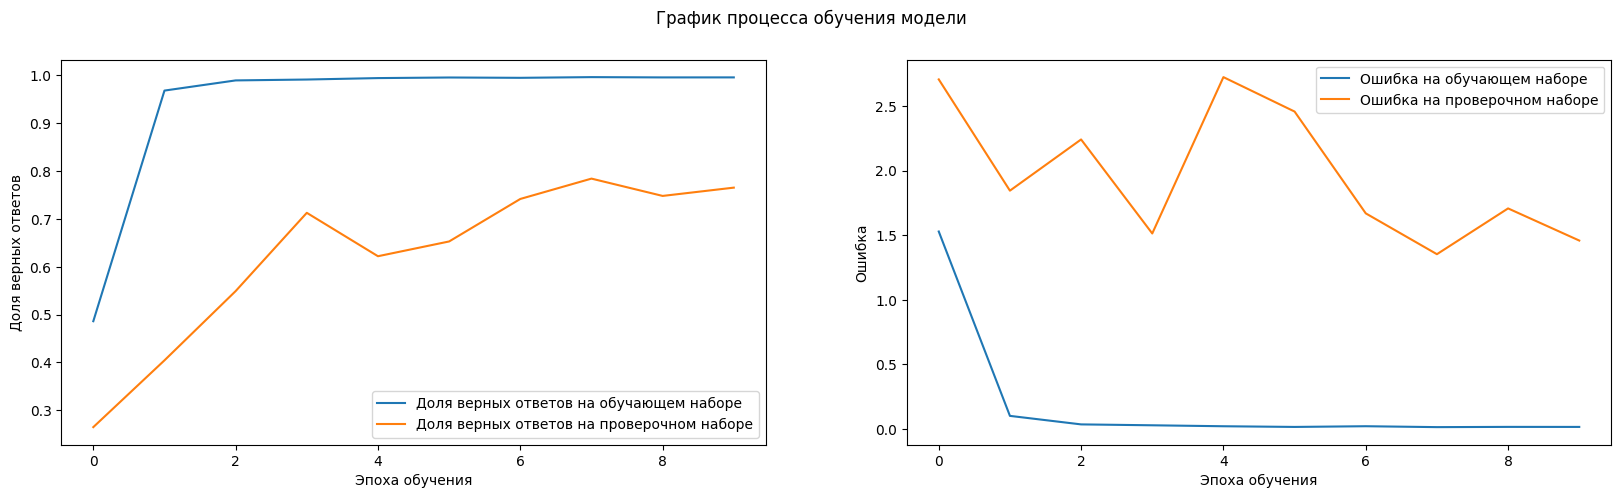

183/183 [==============================] - 5s 24ms/step
----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/20
Класс: Беляев                62% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Гоголь                71% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Горький               92% сеть отнесла к классу Горький              - ВЕРНО :-)
Класс: Грибоедов             92% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Достоевский           65% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Куприн                64% сеть отнесла к классу Куприн               - ВЕРНО :-)
Класс: Лермонтов             72% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Носов                 84% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Пастернак             97% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Пушкин              

In [20]:
#Создаём сеть с Embedding слоем
model_text_emb_200 = Sequential()
model_text_emb_200.add(Embedding(VOCAB_SIZE, 200, input_length=seq_max_len))

model_text_emb_200.add(Conv1D(128, 10, padding="valid", activation="relu", strides=3))
model_text_emb_200.add(Conv1D(256, 10, padding="valid", activation="relu", strides=3))
model_text_emb_200.add(GlobalMaxPooling1D())

#model_text_emb_200.add(SpatialDropout1D(0.2))
model_text_emb_200.add(Flatten())
model_text_emb_200.add(BatchNormalization())
model_text_emb_200.add(Dense(200, activation="relu"))
model_text_emb_200.add(Dropout(0.3))
model_text_emb_200.add(Dense(200, activation="relu"))
model_text_emb_200.add(Dropout(0.3))
#model_text_emb_200.add(BatchNormalization())
model_text_emb_200.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_200,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=10,
                         class_labels=CLASS_LIST,
                         title='Embedding/20')